In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
from matplotlib.pyplot import hist

In [3]:
import gc

In [4]:
import spatialdm as sdm
import spatialdm.plottings as pl

In [5]:
import squidpy as sq

/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [6]:
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

In [7]:
# sq.gr.spatial_neighbors(adata)
# sq.gr.nhood_enrichment(adata, cluster_key="cluster")
# sq.pl.nhood_enrichment(adata, cluster_key="cluster")

Set up

In [8]:
## SpatialDM tutorial data
# adata = sdm.datasets.melanoma()
# raw = pd.DataFrame(adata.raw.X, index=adata.obs_names, columns=adata.raw.var_names)
# log = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

In [9]:
# raw = pd.DataFrame(adata.raw.X.todense(), index=adata.obs_names, columns=adata.raw.var_names)
log = pd.DataFrame(adata.X.todense(), index=adata.obs_names, columns=adata.var_names)
raw = log # yeah raw is just dumb

In [10]:
spatialcoord = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x','y'])

In [11]:
# Preprocessing
my_sample = sdm.SpatialDM(log, raw, spatialcoord)     # load spatial data with simply log, raw, spatial input

In [12]:
my_sample.extract_lr(species='mouse', min_cell=3)

We set radial basis kernel parameter l = 1.2, and trimmed all weights < 0.2 (cutoff) to match the normal range of CCC (200 micrometers, 1 spot away from the sender cell here)

In [13]:
?my_sample.weight_matrix

Signature:
my_sample.weight_matrix(
    l,
    cutoff=None,
    n_neighbors=None,
    single_cell=False,
)
Docstring:
compute weight matrix based on radial basis kernel.
cutoff & n_neighbors are two alternative options to         make the matrix sparse
:param l: radial basis kernel parameter, need to be customized to restrain the range of signaling
 before downstream processing.
:param cutoff: minimum weight to be kept from the rbf weight matrix. Weight below cutoff will be made zero
:param n_neighbors: number of neighbors per spot from the rbf weight matrix.
Non-neighbors will be made 0
:param single_cell: if single cell resolution, diagonal will be made 0.
:return: rbf_d weight matrix in obj attribute
File:      ~/anaconda3/lib/python3.8/site-packages/spatialdm/main.py
Type:      method


In [14]:
my_sample.weight_matrix(l=200, cutoff=0.2, single_cell=False)  # Not single-cell resolution

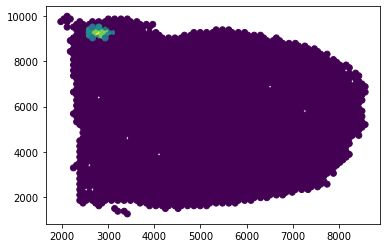

In [15]:
import matplotlib.pyplot as plt
plt.scatter(my_sample.spatialcoord.x, my_sample.spatialcoord.y, c=my_sample.rbf_d[50])

In [16]:
my_sample.rbf_d

array([[0.09545454, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.09545454, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.09545454, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.09545454, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.09545454,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09545454]], dtype=float32)

Global Moran's I

In [17]:
%%time
# Global selection of significant pairs
my_sample.spatialdm_global(1000, method='both', select_num=None)  # complete in seconds
my_sample.sig_pairs(method='permutation', fdr=True, threshold=0.1)  # select significant pairs

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f6838709940>
Traceback (most recent call last):
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
100%|██████████| 1000/1000 [01:29<00:00, 11.18it/s]

CPU times: user 1min 30s, sys: 700 ms, total: 1min 31s
Wall time: 1min 30s


Moran's global I per LR across the slide

In [18]:
res = my_sample.global_res

In [19]:
res['global_I'] = my_sample.global_I

In [20]:
res

,ligand,receptor,z_pval,perm_pval,fdr,selected,global_I
TGFB1_TGFBR1_TGFBR2,[Tgfb1],"[Tgfbr1, Tgfbr2]",1.358336e-03,0.005,0.017282,True,0.014367
TGFB2_TGFBR1_TGFBR2,[Tgfb2],"[Tgfbr1, Tgfbr2]",2.106223e-06,0.000,0.000000,True,0.022046
TGFB3_TGFBR1_TGFBR2,[Tgfb3],"[Tgfbr1, Tgfbr2]",6.077916e-04,0.001,0.003976,True,0.015503
TGFB1_ACVR1B_TGFBR2,[Tgfb1],"[Acvr1b, Tgfbr2]",7.077262e-01,0.636,0.943358,False,-0.002620
TGFB1_ACVR1C_TGFBR2,[Tgfb1],"[Acvr1c, Tgfbr2]",1.675236e-02,0.080,0.201605,False,0.010188
...,...,...,...,...,...,...,...
THY1_ITGAV_ITGB3,[Thy1],"[Itgav, Itgb3]",2.294317e-13,0.000,0.000000,True,0.034679
ITGA4_ITGB1_VCAM1,"[Itga4, Itgb1]",[Vcam1],4.597333e-14,0.000,0.000000,True,0.035709
ITGA9_ITGB1_VCAM1,"[Itga9, Itgb1]",[Vcam1],2.971824e-21,0.000,0.000000,True,0.045001
ITGA4_ITGB7_VCAM1,"[Itga4, Itgb7]",[Vcam1],4.024622e-01,0.406,0.706515,False,0.001184


In [21]:
res[res.index.str.contains('SEMA4D_PLXNB3')][res.global_I > 0.2].sort_values(by='global_I')

<ipython-input-21-52149b07629a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res[res.index.str.contains('SEMA4D_PLXNB3')][res.global_I > 0.2].sort_values(by='global_I')


,ligand,receptor,z_pval,perm_pval,fdr,selected,global_I
SEMA4D_PLXNB3,[Sema4d],[Plxnb3],0.0,0.0,0.0,True,0.252307


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


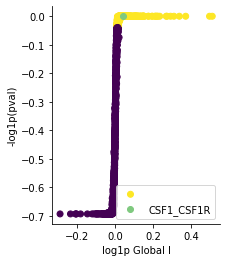

In [22]:
pl.global_plot(my_sample, pairs=['CSF1_CSF1R'])  # Overview of global selection

Local Moran's I

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f67f13323a0>
Traceback (most recent call last):
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
100%|██████████| 100/100 [00:04<00:00, 21.27it/s]


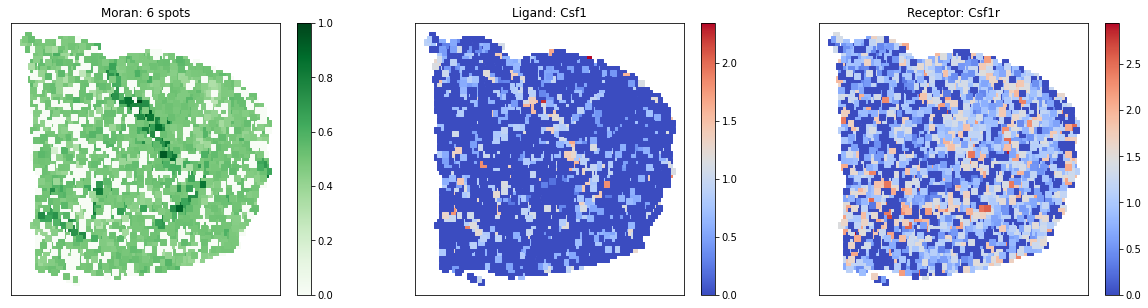

In [23]:
# Local selection of significant spots
my_sample.spatialdm_local(n_perm=100, method='both', select_num=None, nproc=1)     # local spot selection complete in seconds
my_sample.sig_spots(threshold=0.1)  # significant local spots
pl.plot_pairs(my_sample, ['CSF1_CSF1R'], marker='s') # visualize known melanoma pair(s)

In [24]:
my_sample.local_z

array([[-0.03327153,  0.04758825, -0.03481388, ...,  0.04929673,
        -0.08068224, -0.01774819],
       [-0.03410134,  0.08548754,  0.18004339, ...,  0.1138151 ,
         0.01778373,  0.05515325],
       [-0.04513461, -0.01262676, -0.02500605, ...,  0.07506425,
        -0.05158299,  0.05559399],
       ...,
       [ 0.16747972, -0.22892143, -0.04475336, ..., -0.0603409 ,
         0.18469236,  0.16073449],
       [ 0.14602556, -0.28771167, -0.05380512, ...,  0.04705104,
         0.16350316,  0.18564742],
       [ 0.10077682,  0.0688538 ,  0.29078784, ...,  0.11504876,
        -0.06974995,  0.07049083]])

Re-implement Moran's Global I

1. DataFrame /w L & R 
2. Calulcate L & R means & props (accounting for complexes)
3. Re-implement radial kernel weight
4. Moran's R
5. p-val /w Permutations
6. z-score pvals

In [25]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [26]:
from liana.method._pipe_utils._pre import prep_check_adata
from liana.resource import select_resource, explode_complexes
from threadpoolctl import threadpool_limits

In [27]:
from liana.method._pipe_utils import prep_check_adata, filter_resource

In [28]:
from liana.method._liana_pipe import filter_reassemble_complexes

In [29]:
_key_cols = ['ligand_complex', 'receptor_complex']

In [30]:
adata = prep_check_adata(adata, groupby='cluster', obsm_keys=['spatial'], min_cells=3)

In [31]:
resource = select_resource('MouseConsensus')

In [32]:
adata.var_names

Index(['0610005C13Rik', '0610009B22Rik', '0610009O20Rik', '0610010F05Rik',
       '0610010K14Rik', '0610012G03Rik', '0610025J13Rik', '0610030E20Rik',
       '0610033M10Rik', '0610037L13Rik',
       ...
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4',
       'mt-Nd4l', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', length=18078)

In [33]:
adata.obsm

AxisArrays with keys: spatial

In [34]:
# # fix this later
# temp = sq.datasets.visium_hne_adata()
# # adata.layers['counts'] = temp.raw.X THIS IS JUST BAD!!
# del temp
# gc.collect()

Process Resource

In [35]:
resource = explode_complexes(resource)

In [36]:
resource = filter_resource(resource, adata.var_names)

In [37]:
resource

,interaction,ligand,receptor,ligand_complex,receptor_complex
0,Dll1|Notch1,Dll1,Notch1,Dll1,Notch1
1,Dll1|Notch2,Dll1,Notch2,Dll1,Notch2
2,Dll1|Notch4,Dll1,Notch4,Dll1,Notch4
3,Dll1|Notch3,Dll1,Notch3,Dll1,Notch3
4,Nrg2|Erbb2_Erbb3,Nrg2,Erbb2,Nrg2,Erbb2_Erbb3
...,...,...,...,...,...
5070,Saa2|Grm7,Saa2,Grm7,Saa2,Grm7
5073,Saa1|Scarb1,Saa1,Scarb1,Saa1,Scarb1
5074,Saa2|Scarb1,Saa2,Scarb1,Saa2,Scarb1
5075,Saa1|Tlr2,Saa1,Tlr2,Saa1,Tlr2


Get slide means

In [38]:
entities = np.union1d(np.unique(resource["ligand"]),
                      np.unique(resource["receptor"]))

In [39]:
# Filter to only include the relevant genes
adata = adata[:, np.intersect1d(entities, adata.var.index)]

In [40]:
lr_stats = pd.DataFrame({'means': adata.X.mean(axis=0).A.flatten(), 
                        'props': adata.X.getnnz(axis=0) / adata.X.shape[0]},
                        index=adata.var_names).reset_index().rename(columns={'index': 'gene'})

In [41]:
def _rename_means(lr_stats, entity):
    df = lr_stats.copy()
    df.columns = df.columns.map(lambda x: entity + '_' + str(x) if x!='gene' else 'gene')
    return df.rename(columns = {'gene':entity})

In [42]:
lr_res = resource.merge(_rename_means(lr_stats, entity='ligand')).merge(_rename_means(lr_stats, entity='receptor'))

In [43]:
# # Filter non-expressed
# lr_res = lr_res[(lr_res.ligand_props > 0.05) & (lr_res.receptor_props > 0.05)]

Recomplexify

In [44]:
lr_res = filter_reassemble_complexes(lr_res=lr_res,
                                     _key_cols=_key_cols,
                                     expr_prop=0.05,
                                     complex_cols=['ligand_means', 'receptor_means'])

In [45]:
lr_res[lr_res.interaction.str.contains('Plxnb3')]

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min
1221,Sema5a|Plxnb3,Sema5a,Plxnb3,Sema5a,Plxnb3,0.418452,0.452009,0.190867,0.219866,0.219866
1222,Sema4d|Plxnb3,Sema4d,Plxnb3,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,0.219866
1223,Sema4a|Plxnb3,Sema4a,Plxnb3,Sema4a,Plxnb3,0.296781,0.383557,0.190867,0.219866,0.219866


For now I will use their spatial kernel weights

In [46]:
rbf_d = my_sample.rbf_d

In [47]:
# every spot to every spot:
my_sample.rbf_d.shape[0]

2688

(Vectorized) For all interactions:

norm expr mat - i.e. (x - x^) & (y - y^)

In [48]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0)))
sqrt_a = np.sqrt(np.sum(np.power(norm_mat, 2), axis=0)).T

In [49]:
ligand_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
              in lr_res['ligand']}
receptor_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
                in lr_res['receptor']}

Calculate Global Moran's R

In [50]:
import scipy
from tqdm import tqdm

In [51]:
# essential for this to be sparse
dist = scipy.sparse.csr_matrix(my_sample.rbf_d)

In [52]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0))) # normalized x matrix

In [53]:
norm_mat = norm_mat / np.sqrt(np.sum(norm_mat**2, axis=0, keepdims=True))

In [54]:
# sqrt_a = np.sqrt(np.sum(np.power(norm_mat, 2), axis=0)).T # sqrt matrix
# positions
ligand_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
              in lr_res['ligand']}
receptor_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
                in lr_res['receptor']}

In [55]:
n_perm = 1000

In [56]:
ligand_mat = np.array([norm_mat[:, ligand_pos[ligand]] for ligand in lr_res.ligand])
receptor_mat = np.array([norm_mat[:, receptor_pos[receptor]] for receptor in lr_res.receptor])
# ligand_sqrt = np.array([sqrt_a[ligand_pos[ligand]] for ligand in lr_res.ligand])
# receptor_sqrt = np.array([sqrt_a[receptor_pos[receptor]] for receptor in lr_res.receptor])

global_r for all

In [57]:
global_r = ((ligand_mat @ dist)* receptor_mat).sum(axis=1)

In [58]:
lr_res['global_r'] = global_r

Create a perm_matrix for all LRs

Permutation p-vals

In [59]:
rng = np.random.default_rng()

In [60]:
idx = norm_mat.shape[0]

In [61]:
# mat /w n_perms x LR_n
perm_mat = np.zeros((n_perm, global_r.shape[0]))

In [62]:
%%time
for perm in tqdm(range(n_perm)):
    _idx = rng.permutation(idx)
    perm_mat[perm,:] = ((ligand_mat[:, _idx] @ dist) * receptor_mat).sum(axis=1)

100%|██████████| 1000/1000 [00:42<00:00, 23.78it/s]

CPU times: user 42.1 s, sys: 77.2 ms, total: 42.2 s
Wall time: 42 s


In [63]:
global_pvals = 1 - (global_r > perm_mat).sum(axis=0) / n_perm

In [64]:
lr_res['global_pvals'] = global_pvals

In [65]:
lr_res.sort_values('global_r')

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,global_r,global_pvals
1658,Gnai2|Adcy1,Gnai2,Adcy1,Gnai2,Adcy1,1.626721,0.966518,1.519379,0.898438,0.898438,-0.281202,1.0
1457,Agt|Mas1,Agt,Mas1,Agt,Mas1,1.153787,0.687128,0.136406,0.172619,0.172619,-0.251796,1.0
1641,Lgi3|Stx1a,Lgi3,Stx1a,Lgi3,Stx1a,1.376733,0.897693,1.109148,0.718750,0.718750,-0.234340,1.0
1339,Apoe|Sorl1,Apoe,Sorl1,Apoe,Sorl1,4.075930,1.000000,1.021082,0.803199,0.803199,-0.223017,1.0
1731,Gad1|Grm4,Gad1,Grm4,Gad1,Grm4,1.216953,0.765997,0.246194,0.273065,0.273065,-0.220525,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1542,Cck|Cckbr,Cck,Cckbr,Cck,Cckbr,2.622576,0.947917,0.295722,0.344494,0.344494,0.248485,0.0
1222,Sema4d|Plxnb3,Sema4d,Plxnb3,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,0.219866,0.252306,0.0
665,Wnt4|Fzd5_Lrp6,Wnt4,Fzd5,Wnt4,Fzd5_Lrp6,0.347955,0.373512,0.072801,0.086682,0.086682,0.255657,0.0
1732,Rims1|Slc17a7,Rims1,Slc17a7,Rims1,Slc17a7,0.628196,0.638393,2.257496,0.891741,0.638393,0.297503,0.0


Z-score p-vals

In [66]:
from scipy import stats

In [67]:
dist = np.array(dist.todense())

In [68]:
# global distance variance (~copy pasted)
n = adata.shape[0]
nm = (n ** 2 * (dist * dist).sum()) - (2 * n * (dist.sum(axis=1) * dist.sum(axis=0)).sum()) + (dist.sum() ** 2)
dm = n ** 2 * (n - 1) ** 2

In [69]:
# squered variance
dist_var = nm/dm  # aka st

In [70]:
dist_var_sq = dist_var ** (1 / 2)

In [71]:
dist_var_sq

0.004791904351092601

In [72]:
global_zscores = global_r / dist_var_sq

In [73]:
global_zpvals = stats.norm.sf(global_zscores)

In [74]:
# assign to LR
lr_res['global_zscores'] = global_zscores

In [75]:
lr_res['global_zpvals'] = global_zpvals

Compare global

In [76]:
lr_res.interaction = lr_res.interaction.str.upper()
lr_res.interaction = lr_res.interaction.str.replace('|', '_')

<ipython-input-76-b09654ff13ad>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [77]:
res = res.reset_index().rename(columns={'index':'interaction'})

In [78]:
res = res[[len(rec) < 2 for rec in res.receptor]]

In [79]:
lr_res[lr_res.interaction=="SEMA4D_PLXNB3"]

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,global_r,global_pvals,global_zscores,global_zpvals
1222,SEMA4D_PLXNB3,Sema4d,Plxnb3,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,0.219866,0.252306,0.0,52.652626,0.0


In [80]:
res[res.interaction=="SEMA4D_PLXNB3"]

,interaction,ligand,receptor,z_pval,perm_pval,fdr,selected,global_I
1481,SEMA4D_PLXNB3,[Sema4d],[Plxnb3],0.0,0.0,0.0,True,0.252307


In [81]:
# If "exponential" the weights are calculated based on the distance to the spatial
# unit \var{j} and the parameter \code{l} using the exponential function
# \deqn{w_{ij} = e^{-\frac{d_{ij}}{l}}}{w(i,j) = exp(-d(i,j)/l)}
# '
# ' The parameter \code{l} here denotes signaling length. For more information
# ' consult Oyler-Yaniv et. al. Immunity 46(4) 2017.
# '
# ' If "linear" the weights are calculated based on the distance to the spatial
# ' unit \var{j} and the parameter \code{l} using the linear function
# ' \deqn{w_{ij} = 1- d(i,j)/l}{w(i,j) = 1- d(i,j)/l}

In [82]:
joined = lr_res.merge(res, on='interaction')

In [83]:
joined.sort_values('global_r')

,interaction,ligand_x,receptor_x,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,...,global_pvals,global_zscores,global_zpvals,ligand_y,receptor_y,z_pval,perm_pval,fdr,selected,global_I
171,AGT_MAS1,Agt,Mas1,Agt,Mas1,1.153787,0.687128,0.136406,0.172619,0.172619,...,1.0,-52.546089,1.000000e+00,[Agt],[Mas1],1.000000e+00,1.0,1.0,False,-0.251794
87,EFNB3_EPHA4,Efnb3,Epha4,Efnb3,Epha4,1.000509,0.746652,1.053368,0.803199,0.746652,...,1.0,-43.735756,1.000000e+00,[Efnb3],[Epha4],1.000000e+00,1.0,1.0,False,-0.209577
71,EFNB3_EPHB6,Efnb3,Ephb6,Efnb3,Ephb6,1.000509,0.746652,0.556755,0.571429,0.571429,...,1.0,-39.255363,1.000000e+00,[Efnb3],[Ephb6],1.000000e+00,1.0,1.0,False,-0.188108
219,PSAP_GPR37,Psap,Gpr37,Psap,Gpr37,3.318095,0.999628,0.798705,0.622396,0.622396,...,1.0,-34.734425,1.000000e+00,[Psap],[Gpr37],1.000000e+00,1.0,1.0,False,-0.166444
220,PSAP_GPR37L1,Psap,Gpr37l1,Psap,Gpr37l1,3.318095,0.999628,1.765455,0.977307,0.977307,...,1.0,-28.380911,1.000000e+00,[Psap],[Gpr37l1],1.000000e+00,1.0,1.0,False,-0.135999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,SST_SSTR2,Sst,Sstr2,Sst,Sstr2,1.590532,0.835938,0.169711,0.230655,0.230655,...,0.0,33.714981,1.743605e-249,[Sst],[Sstr2],1.717506e-249,0.0,0.0,True,0.161561
82,EFNB3_EPHB1,Efnb3,Ephb1,Efnb3,Ephb1,1.000509,0.746652,0.332816,0.390625,0.390625,...,0.0,39.755390,0.000000e+00,[Efnb3],[Ephb1],0.000000e+00,0.0,0.0,True,0.190505
65,FGF1_FGFR2,Fgf1,Fgfr2,Fgf1,Fgfr2,0.509576,0.533110,0.460559,0.448289,0.448289,...,0.0,40.244083,0.000000e+00,[Fgf1],[Fgfr2],0.000000e+00,0.0,0.0,True,0.192844
192,CCK_CCKBR,Cck,Cckbr,Cck,Cckbr,2.622576,0.947917,0.295722,0.344494,0.344494,...,0.0,51.855198,0.000000e+00,[Cck],[Cckbr],0.000000e+00,0.0,0.0,True,0.248487


In [84]:
import scipy

In [85]:
joined

,interaction,ligand_x,receptor_x,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,...,global_pvals,global_zscores,global_zpvals,ligand_y,receptor_y,z_pval,perm_pval,fdr,selected,global_I
0,DLL1_NOTCH1,Dll1,Notch1,Dll1,Notch1,0.037283,0.057292,0.216689,0.276786,0.057292,...,0.101,1.566856,5.857417e-02,[Dll1],[Notch1],5.857425e-02,0.092,0.226542,False,0.007508
1,JAG1_NOTCH1,Jag1,Notch1,Jag1,Notch1,0.051299,0.075893,0.216689,0.276786,0.075893,...,0.528,-0.106792,5.425232e-01,[Jag1],[Notch1],5.425237e-01,0.536,0.856577,False,-0.000512
2,DLK1_NOTCH1,Dlk1,Notch1,Dlk1,Notch1,0.236641,0.213542,0.216689,0.276786,0.213542,...,1.000,-4.013590,9.999701e-01,[Dlk1],[Notch1],9.999701e-01,0.999,1.000000,False,-0.019233
3,DLL3_NOTCH1,Dll3,Notch1,Dll3,Notch1,0.108551,0.161086,0.216689,0.276786,0.161086,...,1.000,-4.284546,9.999908e-01,[Dll3],[Notch1],9.999908e-01,1.000,1.000000,False,-0.020531
4,JAG2_NOTCH1,Jag2,Notch1,Jag2,Notch1,0.273678,0.364583,0.216689,0.276786,0.276786,...,1.000,-5.815392,1.000000e+00,[Jag2],[Notch1],1.000000e+00,1.000,1.000000,False,-0.027867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,ENTPD1_ADORA1,Entpd1,Adora1,Entpd1,Adora1,0.089811,0.128720,0.846592,0.736979,0.128720,...,0.497,-0.064482,5.257069e-01,[Entpd1],[Adora1],5.257070e-01,0.511,0.828931,False,-0.000309
219,PSAP_GPR37,Psap,Gpr37,Psap,Gpr37,3.318095,0.999628,0.798705,0.622396,0.622396,...,1.000,-34.734425,1.000000e+00,[Psap],[Gpr37],1.000000e+00,1.000,1.000000,False,-0.166444
220,PSAP_GPR37L1,Psap,Gpr37l1,Psap,Gpr37l1,3.318095,0.999628,1.765455,0.977307,0.977307,...,1.000,-28.380911,1.000000e+00,[Psap],[Gpr37l1],1.000000e+00,1.000,1.000000,False,-0.135999
221,TAC1_TACR1,Tac1,Tacr1,Tac1,Tacr1,0.364385,0.326637,0.046681,0.070685,0.070685,...,0.000,30.941650,1.645298e-210,[Tac1],[Tacr1],1.640881e-210,0.000,0.000000,True,0.148270


In [86]:
scipy.stats.pearsonr(joined.fdr,  joined.global_pvals)

(0.9660974646491798, 5.999369463674745e-132)

In [87]:
scipy.stats.pearsonr(joined.z_pval,  joined.global_zpvals)

(0.9999999999960448, 0.0)

### Local Moran's I

In [107]:
import scipy

In [108]:
dist = scipy.sparse.csr_matrix(my_sample.rbf_d)

In [109]:
# norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0))) # normalized x matrix
# Note here - there is no normalisation by the squares

In [110]:
norm_mat = np.array(adata.X - np.array(adata.X.mean(axis=0)))

In [111]:
ligand_mat = np.array([norm_mat[:, ligand_pos[ligand]] for ligand in lr_res.ligand]).T
receptor_mat = np.array([norm_mat[:, receptor_pos[receptor]] for receptor in lr_res.receptor]).T

In [112]:
# where at least one is positive
(np.array([-1, 0, 1, -1, 1]) > 0) | (np.array([-1, 0, 1, -1, -1]) > 0)

array([False, False,  True, False,  True])

In [113]:
# where either L or R is positive
pos_msk = ((ligand_mat > 0) + (receptor_mat > 0)).T

In [114]:
# calculate both sides for local_Rs
local_x = ligand_mat * (dist @ receptor_mat) # local_I
local_y = receptor_mat * (dist @ ligand_mat) # local_I_R

mask?

In [96]:
# also only sig on global (i.e. only positive by default)?
lr_msk = global_pvals <= 0.05

In [97]:
# he used to filter spot to spot to be positive
# i guess to exclude - to - positive correlations (does this even make sense...)

In [98]:
local_x = local_x[:, lr_msk]
local_y = local_y[:, lr_msk]
assert local_x.shape == local_y.shape

In [99]:
receptor_mat = receptor_mat[:, lr_msk]
ligand_mat = ligand_mat[:, lr_msk]

Permutations

In [115]:
spot_n = local_x.shape[0]
lr_n = local_x.shape[1]
n_perm = 25

In [116]:
perm_x = np.zeros((lr_n, n_perm, spot_n))
perm_y = np.zeros((lr_n, n_perm, spot_n))

In [117]:
for i in tqdm(range(n_perm)):
    _idx = np.random.permutation(ligand_mat.shape[0]) # TODO RNG
    perm_x[:, i,:] = ((dist @ receptor_mat[_idx, :]) * ligand_mat).T
    perm_y[:, i,:] = ((dist @ ligand_mat[_idx, :]) * receptor_mat).T


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


In [118]:
local_pvals = ((np.expand_dims(local_x.T + local_y.T, 1) <= (perm_x + perm_y)).sum(1)) / n_perm

In [119]:
local_r = local_x + local_y # actual value

Compare local pvals

In [105]:
# # positve to positive local only
# pos = ((ligand_mat > 0) + (receptor_mat > 0)).T # he does it on non-norm counts, and not -mu^
# pvals_msked = local_pvals
# pvals_msked[pos] = 1

In [120]:
ours = pd.DataFrame(local_pvals, index=lr_res.interaction).reset_index()

In [121]:
ours

,interaction,0,1,2,3,4,5,6,7,8,...,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687
0,DLL1_NOTCH1,0.72,0.12,0.32,0.20,0.92,0.52,0.76,0.44,0.84,...,0.68,0.56,0.52,1.00,0.00,0.00,0.84,0.40,0.40,0.16
1,ADAM10_NOTCH1,0.44,0.12,0.84,0.16,0.12,0.60,0.24,0.84,0.80,...,0.92,0.44,0.72,0.28,0.04,0.36,0.20,0.08,0.60,0.76
2,JAG1_NOTCH1,0.56,0.08,0.52,0.80,0.32,0.48,0.04,0.40,0.88,...,0.80,0.40,0.64,1.00,0.04,1.00,0.56,0.68,0.32,0.92
3,ADAM17_NOTCH1,1.00,0.04,1.00,0.96,0.52,0.68,0.08,0.44,0.96,...,0.92,0.88,0.72,0.00,0.88,0.04,0.52,0.24,0.32,0.08
4,DLK1_NOTCH1,0.28,0.00,0.00,0.20,0.72,0.92,0.36,0.04,1.00,...,0.72,0.72,1.00,0.48,0.00,1.00,1.00,1.00,0.24,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,GAD1_GRM4,0.24,1.00,0.08,1.00,1.00,0.00,1.00,1.00,0.60,...,0.00,1.00,0.00,0.00,0.96,0.20,0.52,1.00,0.96,0.96
1405,RIMS1_SLC17A7,0.00,0.00,0.00,1.00,0.00,0.12,1.00,0.36,0.76,...,1.00,0.32,0.00,0.00,1.00,0.12,0.84,0.00,0.96,0.00
1406,NUCB2_ERAP1,0.12,0.56,0.44,0.32,0.52,0.16,0.00,1.00,0.04,...,0.16,0.16,0.76,0.04,0.48,0.96,0.96,0.40,0.08,0.64
1407,FSTL5_SDK2,0.12,0.16,0.08,0.04,0.24,1.00,0.00,0.92,0.88,...,0.28,0.52,1.00,0.96,0.36,0.00,0.52,1.00,0.28,0.00


In [122]:
theirs =  my_sample.local_perm_p.reset_index().rename(columns={'index':'interaction'})

In [123]:
theirs[theirs.interaction=="SEMA4D_PLXNB3"]

,interaction,0,1,2,3,4,5,6,7,8,...,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687
531,SEMA4D_PLXNB3,1.0,1.0,1.0,1.0,1.0,0.5,0.98,1.0,0.0,...,1.0,0.99,0.41,0.01,0.94,0.0,1.0,1.0,0.15,0.46


In [124]:
ours[ours.interaction=="SEMA4D_PLXNB3"]

,interaction,0,1,2,3,4,5,6,7,8,...,2678,2679,2680,2681,2682,2683,2684,2685,2686,2687
903,SEMA4D_PLXNB3,0.0,0.0,0.24,0.0,0.16,0.56,1.0,0.0,0.0,...,0.72,0.96,0.36,0.0,0.84,0.0,0.92,0.36,0.04,0.6


In [125]:
# if both are negative, set to 1
local_pvals[~pos_msk] = 1

In [126]:
scipy.stats.pearsonr(local_pvals[903], my_sample.local_perm_p.iloc[526,:])

(-0.041819459044546675, 0.030150430004846494)

In [127]:
lr_res[lr_res.interaction=="SEMA4D_PLXNB3"]

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min,global_r,global_pvals,global_zscores,global_zpvals
1222,SEMA4D_PLXNB3,Sema4d,Plxnb3,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,0.219866,0.252306,0.0,52.652626,0.0


In [128]:
my_sample.ind_sel[532]

'SEMA5A_PLXNA3'

In [131]:
scipy.stats.pearsonr(local_x[:, 903], my_sample.local_I[:,531])

(0.9999999999999549, 0.0)

In [132]:
scipy.stats.pearsonr(local_y[:, 903], my_sample.local_I_R[:,531])

(0.9999999999999847, 0.0)

(array([  68., 1974.,  456.,   69.,   47.,   35.,   28.,    7.,    2.,
           2.]),
 array([-0.346038  , -0.13335863,  0.07932077,  0.29200014,  0.50467956,
         0.71735895,  0.93003833,  1.1427177 ,  1.3553971 ,  1.5680765 ,
         1.7807559 ], dtype=float32),
 <BarContainer object of 10 artists>)

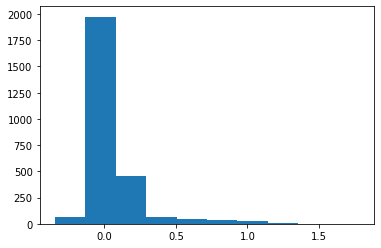

In [133]:
hist(local_x[:, 903])

(array([  68., 1974.,  456.,   69.,   47.,   35.,   28.,    7.,    2.,
           2.]),
 array([-0.34603791, -0.13335857,  0.07932077,  0.29200012,  0.50467946,
         0.7173588 ,  0.93003815,  1.14271749,  1.35539684,  1.56807618,
         1.78075552]),
 <BarContainer object of 10 artists>)

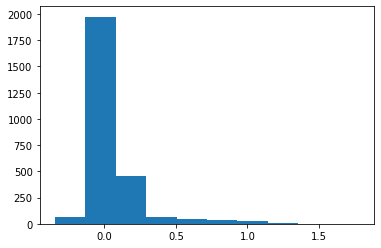

In [134]:
hist(my_sample.local_I[:,531])

compare pvals

In [135]:
scipy.stats.pearsonr(local_pvals[903,:], my_sample.local_perm_p.iloc[531,:])

(0.8680647973073411, 0.0)

zscore p-val

In [147]:
from scipy import stats

In [148]:
dist = scipy.sparse.csr_matrix(my_sample.rbf_d)
wij_sq = (np.array(dist.todense()) ** 2).sum(axis=1)

In [149]:
my_sample.local_permI.shape

(540, 100, 2688)

In [151]:
ligand_norm = np.array([stats.norm.fit(ligand_mat[:, ligand]) for ligand in range(ligand_mat.shape[1])])
receptor_norm = np.array([stats.norm.fit(receptor_mat[:, receptor]) for receptor in range(receptor_mat.shape[1])])

In [152]:
# get ligand receptor mu and std
ligand_mu1, ligand_std = ligand_norm[:,0], ligand_norm[:,1]
receptor_mu1, receptor_std = receptor_norm[:,0], receptor_norm[:,1]

In [153]:
ligand_sigma_sq = [(std * spot_n / (spot_n - 1)) for std in ligand_std]
receptor_sigma_sq = [(std * spot_n / (spot_n - 1)) for std in receptor_std]

In [155]:
def compute_var_local(sigma1_sq, sigma2_sq, wij_sq, spot_n):
    var_I = 2 * (spot_n-1)**2/spot_n**2 * sigma1_sq * sigma2_sq * wij_sq + \
        2 * (spot_n-1)**2/spot_n**2 * sigma1_sq * sigma2_sq
    std_I=var_I**(1/2)
    
    return std_I

In [156]:
std_ls = [compute_var_local(sigma1_sq, sigma2_sq, wij_sq, spot_n) for (sigma1_sq, sigma2_sq) in zip(ligand_sigma_sq, receptor_sigma_sq)]

In [157]:
local_zscores = local_x.T + local_y.T / std_ls

In [158]:
local_zpvals = stats.norm.sf(local_zscores)

In [159]:
local_zpvals

array([[0.50869132, 0.49190161, 0.49972634, ..., 0.49625299, 0.49619869,
        0.49068238],
       [0.49540568, 0.46196512, 0.54617824, ..., 0.45044853, 0.49871004,
        0.51181105],
       [0.50056916, 0.48969589, 0.49300504, ..., 0.50957293, 0.49016215,
        0.52103791],
       ...,
       [0.49094941, 0.50033178, 0.4905001 , ..., 0.50206732, 0.42910902,
        0.50082197],
       [0.49603545, 0.48453422, 0.49535414, ..., 0.61983305, 0.48275755,
        0.48323617],
       [0.49101892, 0.50025191, 0.51550513, ..., 0.49612822, 0.48543675,
        0.53481969]])

In [160]:
local_zscores.shape

(1409, 2688)

In [161]:
local_zscores

array([[-0.02178763,  0.02030106,  0.00068598, ...,  0.00939251,
         0.0095286 ,  0.02335792],
       [ 0.01151651,  0.0954842 , -0.1160114 , ...,  0.12452823,
         0.00323346, -0.02961023],
       [-0.00142668,  0.02583146,  0.01753467, ..., -0.02399807,
         0.02466234, -0.0527587 ],
       ...,
       [ 0.02268841, -0.00083166,  0.02381497, ..., -0.00518202,
         0.17864299, -0.00206037],
       [ 0.00993782,  0.03877669,  0.01164572, ..., -0.30504236,
         0.04323389,  0.04203307],
       [ 0.02251412, -0.00063144, -0.03887537, ...,  0.00970526,
         0.03651277, -0.08739113]], dtype=float32)

In [166]:
scipy.stats.pearsonr(local_zscores[903], my_sample.local_z[531,:])

(0.9978002751298826, 0.0)

In [167]:
# if both are negative, set to 1
local_zpvals[~pos_msk] = 1

In [168]:
scipy.stats.pearsonr(local_zpvals[903,:], my_sample.local_z_p.iloc[531,:])

(0.9160040965111409, 0.0)

(array([ 116.,   45.,   45.,   87.,  612.,  661.,   19.,    3.,    0.,
        1100.]),
 array([1.09610714e-06, 1.00000986e-01, 2.00000877e-01, 3.00000767e-01,
        4.00000658e-01, 5.00000548e-01, 6.00000438e-01, 7.00000329e-01,
        8.00000219e-01, 9.00000110e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

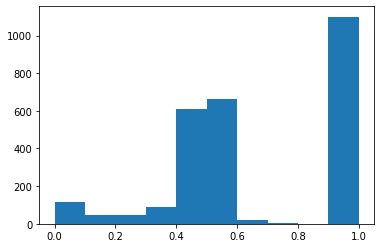

In [169]:
hist(my_sample.local_z_p.iloc[531,:])

(array([ 105.,   38.,   44.,   81.,  507.,  639.,   16.,    3.,    0.,
        1255.]),
 array([5.43631877e-06, 1.00004893e-01, 2.00004349e-01, 3.00003805e-01,
        4.00003262e-01, 5.00002718e-01, 6.00002175e-01, 7.00001631e-01,
        8.00001087e-01, 9.00000544e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

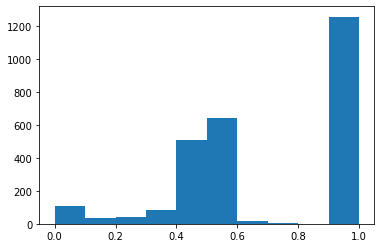

In [170]:
hist(local_zpvals[903,:])

In [165]:
scipy.stats.pearsonr(local_pvals[3], local_zpvals[3])

(0.7984395353412879, 0.0)